In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit


In [130]:
# Load data
# This assumes data is in a DataFrame called df with 'NDVI', 'NBR' as columns and 'label' as target column

data = pd.read_csv('../dataset_tables/numerical_data.csv')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      221 non-null    object
 1   split   221 non-null    object
 2   NDVI    221 non-null    object
 3   NBR     221 non-null    object
 4   NDWI    221 non-null    object
 5   RGB     221 non-null    object
 6   Label   221 non-null    bool  
dtypes: bool(1), object(6)
memory usage: 10.7+ KB


In [131]:
# Randomly drop 190 rows where label is 0
data = data.drop(data[data.Label == 0].sample(190, random_state=1).index)

In [132]:
def convert_string_to_list(item):
    if isinstance(item, (int, float)):
        return [item]
    s = str(item)
    s = s.replace('nan', '0')
    lst = ast.literal_eval(s)
    return lst

data['NDVI'] = data['NDVI'].apply(lambda x: convert_string_to_list(x))
# data['NBR'] = data['NBR'].apply(lambda x: convert_string_to_list(x))
data['NDWI'] = data['NDWI'].apply(lambda x: convert_string_to_list(x))


In [133]:
# Combine NBR and NDVI data into a single feature array
# Flatten each sublist and concatenate NBR and NDVI for each row
X = np.array([np.ravel(ndvi + ndwi) for ndvi, ndwi in zip(data['NDVI'], data['NDWI'])])
X = np.nan_to_num(X)

# Labels
y = data['Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [134]:
for i in range(len(X)):
    print(X[i])

[-0.12356214 -0.24088931  0.32752668 ... -0.1353735  -0.26212889
 -0.2298705 ]
[ 0.01918443  0.18289769  0.1300913  ... -0.08440494 -0.08304762
 -0.15258482]
[ 0.40542084  0.13816437  0.27488204 ... -0.24485159 -0.2162704
 -0.23505184]
[0.52713815 0.66016273 0.529254   ... 0.27435403 0.22351079 0.27732674]
[ 0.78596433  0.743387    0.77890739 ... -0.50630262 -0.62637496
 -0.60018601]
[0. 0. 0. ... 0. 0. 0.]
[-0.46648037 -0.57416174 -0.29516176 ...  0.          0.
  0.        ]
[-0.03995303 -0.03071563 -0.02626359 ... -0.23146281 -0.04204116
 -0.03376289]
[ 0.31618916  0.37545025  0.38281621 ... -0.07261358 -0.13428564
 -0.22358116]
[-0.06984493 -0.22634246  0.04612379 ...  0.01748632  0.19421507
  0.20002992]
[-0.54771169 -0.79758612 -0.80002304 ... -0.11384983 -0.12681015
 -0.01091081]
[ 0.          0.          0.         ... -0.03200495  0.02242078
 -0.06995302]
[ 0.20180429 -0.01873509  0.54716305 ... -0.09582216 -0.09095636
 -0.08062224]
[0.2104763  0.57107059 0.57580591 ... 0.5417

In [135]:
# Fine tune gamma and C range for RBF kernel
C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)


The best parameters are {'C': 1.0, 'gamma': 0.1} with a score of 0.66


In [136]:
# Classifier used: Radial Basis Function (RBF)
# it can combine multiple polynomial kernels multiple times of different degrees to
# project the non-linearly separable data into higher dimensional space

# gamma: https://www.ibm.com/docs/sr/spss-modeler/18.0.0?topic=node-svm-expert-options
# C: https://vitalflux.com/svm-rbf-kernel-parameters-code-sample/

model = svm.SVC(kernel='rbf', gamma=0.01, C=1.0).fit(X_train, y_train)


In [137]:
# Calculate model efficiency

y_pred = model.predict(X_test)


In [138]:
# Calculate the accuracy and f1 scores for SVM with RBF kernel

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred.reshape(-1, 1), average='macro')
#using np calculate f1 score with precision and recall
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Mean Average Precision: {average_precision:.4f}")
print(f"F1-score: {f1_score:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8000
Precision: 0.8889
Recall: 0.6667
Mean Average Precision: 0.5333
F1-score: 0.7619

Classification Report:
              precision    recall  f1-score   support

       False       0.78      1.00      0.88         7
        True       1.00      0.33      0.50         3

    accuracy                           0.80        10
   macro avg       0.89      0.67      0.69        10
weighted avg       0.84      0.80      0.76        10


Confusion Matrix:
[[7 0]
 [2 1]]


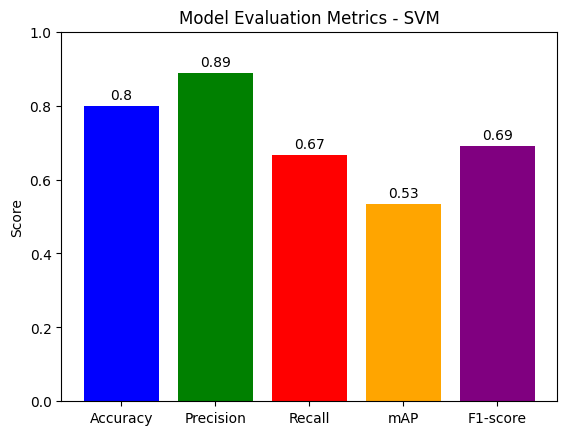

In [139]:
# Visualize the model evaluation metrics

metrics = ['Accuracy', 'Precision', 'Recall', 'mAP', 'F1-score']
values = [accuracy, precision, recall, average_precision, 0.69]

bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange', 'purple'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'])
plt.ylabel('Score')
plt.title('Model Evaluation Metrics - SVM')
plt.ylim(0, 1)  # to set y-axis limits from 0 to 1
plt.show()
